# Simple RFM Analysis

**Description:** RFM Analysis on a simple e-commerce dataset<br>
                 using kaggle data <br>

**Dataset:** https://www.kaggle.com/carrie1/ecommerce-data <br>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time, warnings
import datetime as dt

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

#warnings.filterwarnings("ignore")

In [2]:
#load the dataset
df = pd.read_csv('./e-commerce_data(kaggle).csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680,France


In [3]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [4]:
df.Country.value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format=("%m/%d/%Y %H:%M"))
date_range = str(df['InvoiceDate'].dt.date.min()) + ' to ' +str(df['InvoiceDate'].dt.date.max())
print('the dataset has orders range: ',date_range)

the dataset has orders range:  2010-12-01 to 2011-12-09


In [6]:
# We select orders for 1 year (2010-12-09 to 2011-12-09), and for UK only (biggest country)
# we delete orders = 0
df1 = df[df['Country']=='United Kingdom']
df1 = df1[df1['Quantity']>0]
df1.dropna(subset=['CustomerID'],how='all',inplace=True)
df1 = df1[df1['InvoiceDate']>= "2010-12-09"]
df1.shape

(342478, 8)

In [7]:
print("Summary")
#exploring the unique values of each attribute
print("Transactions: ", df1['InvoiceNo'].nunique())
print("Products: ",df1['StockCode'].nunique())
print("Customers:", df1['CustomerID'].nunique() )
print("Dates Range",str(df1['InvoiceDate'].dt.date.min()) + ' to ' +str(df1['InvoiceDate'].dt.date.max())),

Summary
Transactions:  16017
Products:  3611
Customers: 3863
Dates Range 2010-12-09 to 2011-12-09


(None,)

# RFM Analysis

**RFM** (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. 

- RECENCY (R): Days since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

## Recency

To calculate recency, we need to choose a date point from which we evaluate **how many days ago was the customer's last purchase**.

In [8]:
#group by customers and check last date of purchase
recency_df = df1.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
recency_df.columns = ['CustomerID','LastPurchasedate']
recency_df.head()

,CustomerID,LastPurchasedate
0,12346,2011-01-18 10:01:00
1,12747,2011-12-07 14:34:00
2,12748,2011-12-09 12:20:00
3,12749,2011-12-06 09:56:00
4,12820,2011-12-06 15:12:00


In [9]:
#calculate recency
last_day = df1['InvoiceDate'].max()
recency_df['Recency'] = recency_df['LastPurchasedate'].apply(lambda x: (last_day - x).days)
recency_df.sort_values(by=['Recency'], inplace=True, ascending=True)

In [10]:
recency_df

,CustomerID,LastPurchasedate,Recency
750,13890,2011-12-08 15:36:00,0
431,13426,2011-12-09 08:59:00,0
3258,17428,2011-12-09 09:45:00,0
553,13599,2011-12-08 16:10:00,0
2734,16688,2011-12-08 15:24:00,0
...,...,...,...
2053,15723,2010-12-10 11:12:00,364
3647,17978,2010-12-09 14:05:00,364
1074,14355,2010-12-09 12:16:00,365
1130,14437,2010-12-09 09:27:00,365


## Frequency

Frequency helps us to know how many times a customer purchased from us. To do that we need to check **how many invoices are registered by the same customer**.

In [11]:
df2=df1
#calculate frequency of purchases
frequency_df = df2.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.sort_values(by=['Frequency'], inplace=True, ascending=False)
frequency_df.head()

,CustomerID,Frequency
3549,17841,7707
894,14096,5111
2,12748,4234
1255,14606,2580
1752,15311,2294


## Monetary

Monetary attribute answers the question: **How much money did the customer spent over time?**

To do that, first, we will create a new column total cost to have the total price per invoice.

In [12]:
df3 = df1
df3['TotalCost'] = df3['Quantity'] * df3['UnitPrice']

In [13]:
monetary_df = df3.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.sort_values(by=['Monetary'], inplace=True, ascending=False)
monetary_df.head()

,CustomerID,Monetary
3729,18102,233736.93
3272,17450,192521.95
2567,16446,168472.50
3314,17511,87591.70
0,12346,77183.60


## Create RFM Table

In [14]:
#merge dataframes
RFM_df = recency_df.merge(frequency_df,on='CustomerID').reset_index()
RFM_df = RFM_df.merge(monetary_df, on='CustomerID').reset_index()
#RFM_df.set_index('CustomerID',inplace=True)
RFM_df.head()

,level_0,index,CustomerID,LastPurchasedate,Recency,Frequency,Monetary
0,0,0,13890,2011-12-08 15:36:00,0,110,1883.81
1,1,1,13426,2011-12-09 08:59:00,0,157,3641.32
2,2,2,17428,2011-12-09 09:45:00,0,319,16903.85
3,3,3,13599,2011-12-08 16:10:00,0,230,4800.83
4,4,4,16688,2011-12-08 15:24:00,0,62,1260.86


In [15]:
rfm_df = RFM_df
rfm_df.drop(columns=['LastPurchasedate','index','level_0'], inplace=True)
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,13890,0,110,1883.81,100.0,78.345845,78.345845
1,13426,0,157,3641.32,100.0,86.034170,86.034170
2,17428,0,319,16903.85,100.0,95.288636,95.288636
3,13599,0,230,4800.83,100.0,91.962206,91.962206
4,16688,0,62,1260.86,100.0,62.658556,62.658556


In [16]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
    rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['CustomerID', 'RFM_Score']].head(7)

,CustomerID,RFM_Score
0,13890,4.08
1,13426,4.41
2,17428,4.80
3,13599,4.66
4,16688,3.41
5,16705,4.73
6,13026,2.87


In [22]:
# rfm score >4.5 : Top Customer
# 4.5 > rfm score > 4 : High Value Customer
# 4>rfm score >3 : Medium value customer
# 3>rfm score>1.6 : Low-value customer
# rfm score<1.6 :Lost Customer
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] > 4.5, "Top Customers", 
                            (np.where(rfm_df['RFM_Score'] > 4,"High value Customer",
                            (np.where(rfm_df['RFM_Score'] > 3,"Medium Value Customer", 
                            (np.where(rfm_df['RFM_Score'] > 1.6,"Low Value Customers", 
                            'Lost Customers')))))))
rfm_df[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)

,CustomerID,RFM_Score,Customer_segment
0,13890,4.08,High value Customer
1,13426,4.41,High value Customer
2,17428,4.80,Top Customers
3,13599,4.66,Top Customers
4,16688,3.41,Medium Value Customer
5,16705,4.73,Top Customers
6,13026,2.87,Low Value Customers
7,17405,3.74,Medium Value Customer
8,13404,1.46,Lost Customers
9,17389,4.61,Top Customers


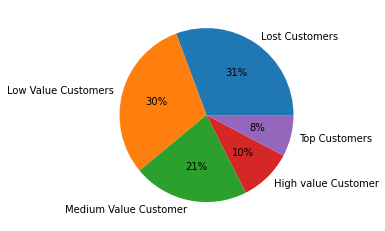

In [21]:
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()